In [1]:
import os
import sys
import gzip
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from urllib.request import urlretrieve
from tqdm import tqdm

In [2]:
%matplotlib inline

#### Dataset Info

In [3]:
# source: http://yann.lecun.com/exdb/mnist/
DATA_URLS = [
    "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
    "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
    "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
    "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"
]

FILE_NAMES = [
    "train-images-idx3-ubyte.gz",
    "train-labels-idx1-ubyte.gz",
    "t10k-images-idx3-ubyte.gz",
    "t10k-labels-idx1-ubyte.gz"
]

IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 10
TRAIN_IMAGES_NUM = 60000
TEST_IMAGES_NUM = 10000

#### Downloading dataset

In [4]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

for url, filename in zip(DATA_URLS, FILE_NAMES):
    if not os.path.isfile(filename):
        with DLProgress(unit="B", unit_scale=True, miniters=1, desc="MNIST:" + filename) as pbar:
            urlretrieve(url, filename, pbar.hook)

#### Extracting data

In [5]:
def extract_data(file_path, num_images):
    with gzip.open(file_path) as bstream:
        bstream.read(16)
        buffer = bstream.read(IMAGE_WIDTH * IMAGE_HEIGHT * num_images)
        data = np.frombuffer(buffer, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, IMAGE_WIDTH, IMAGE_HEIGHT, 1)
        return data

In [6]:
def extract_labels(file_path, num_images):
    with gzip.open(file_path) as bstream:
        bstream.read(8)
        buffer = bstream.read(1 * num_images)
        labels = np.frombuffer(buffer, dtype=np.uint8).astype(np.int64)
    return labels

In [7]:
trainX_raw = extract_data("train-images-idx3-ubyte.gz", TRAIN_IMAGES_NUM)
trainY_raw = extract_labels("train-labels-idx1-ubyte.gz", TRAIN_IMAGES_NUM)
testX_raw = extract_data("t10k-images-idx3-ubyte.gz", TEST_IMAGES_NUM)
testY_raw = extract_labels("t10k-labels-idx1-ubyte.gz", TEST_IMAGES_NUM)

#### Present extracted data

In [8]:
def show_digit(trainX_raw, trainY_raw, index):
    image = trainX_raw[index].reshape([IMAGE_WIDTH, IMAGE_HEIGHT])
    label = trainY_raw[index]
    plt.title("Training data, index: {},  Label: {}".format(index, label))
    plt.imshow(image, cmap="gray_r")
    plt.show()

trainX_raw shape: (60000, 28, 28, 1)
trainY_raw shape: (60000,)
testX_raw shape: (10000, 28, 28, 1)
testY_raw shape: (10000,)


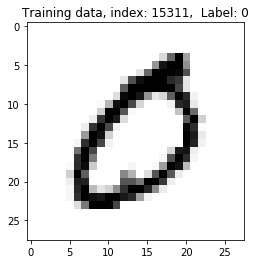

In [9]:
print("trainX_raw shape: " + str(trainX_raw.shape))
print("trainY_raw shape: " + str(trainY_raw.shape))
print("testX_raw shape: " + str(testX_raw.shape))
print("testY_raw shape: " + str(testY_raw.shape))
show_digit(trainX_raw, trainY_raw, np.random.randint(1, TRAIN_IMAGES_NUM + 1))

#### Preprocess data

In [10]:
def normalize(x, pixel_depth):
    return x / pixel_depth

In [11]:
def one_hot_encode(x, labels_num):
    rows = len(x)

    encoding_array = np.zeros([rows, labels_num])
    for row in range(0, rows):
        label = x[row] - 1
        encoding_array[row][label] = 1

    return encoding_array

In [12]:
trainX_processed = normalize(
    np.reshape(trainX_raw, (TRAIN_IMAGES_NUM, IMAGE_WIDTH * IMAGE_HEIGHT)), PIXEL_DEPTH)

testX_processed = normalize(
    np.reshape(testX_raw, (TEST_IMAGES_NUM, IMAGE_WIDTH * IMAGE_HEIGHT)), PIXEL_DEPTH)

In [13]:
print("trainX_raw shape: " + str(trainX_raw.shape) + ", min: " 
      + str(np.min(trainX_raw)) + ", max: " + str(np.max(trainX_raw)))

print("testX_raw shape: " + str(testX_raw.shape) + ", min: " 
      + str(np.min(testX_raw)) + ", max: " + str(np.max(testX_raw)))

print("trainX_processed shape: " + str(trainX_processed.shape) 
      + ", min: " + str(np.min(trainX_processed)) + ", max: " + str(np.max(trainX_processed)))

print("testX_processed shape: " + str(testX_processed.shape) 
      + ", min: " + str(np.min(testX_processed)) + ", max: " + str(np.max(testX_processed)))

trainX_raw shape: (60000, 28, 28, 1), min: 0.0, max: 255.0
testX_raw shape: (10000, 28, 28, 1), min: 0.0, max: 255.0
trainX_processed shape: (60000, 784), min: 0.0, max: 1.0
testX_processed shape: (10000, 784), min: 0.0, max: 1.0


In [14]:
trainY_processed = one_hot_encode(trainY_raw, NUM_LABELS)
testY_processed = one_hot_encode(testY_raw, NUM_LABELS)

In [15]:
random_train_index = np.random.randint(1, TRAIN_IMAGES_NUM + 1)
random_test_index = np.random.randint(1, TEST_IMAGES_NUM + 1)

print("Label on pos: " + str(random_train_index) + " equals " 
      + str(trainY_raw[random_train_index]) + ", OHE tensor: " 
      + str(trainY_processed[random_train_index]))

print("Label on pos: " + str(random_test_index) + " equals " 
      + str(testY_raw[random_test_index]) + ", OHE tensor: " 
      + str(testY_processed[random_test_index]))

Label on pos: 15250 equals 3, OHE tensor: [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
Label on pos: 8475 equals 7, OHE tensor: [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


#### Divide data

In [16]:
VALIDATION_DATA_PERCENTAGE = 0.1

In [17]:
val_samples = int(TRAIN_IMAGES_NUM * VALIDATION_DATA_PERCENTAGE)

In [18]:
train_dataX = trainX_processed[val_samples:]
train_dataY = trainY_processed[val_samples:]
val_dataX = trainX_processed[:val_samples]
val_dataY = trainY_processed[:val_samples]

In [19]:
print("train_dataX shape: " + str(train_dataX.shape))
print("train_dataY shape: " + str(train_dataY.shape))
print("val_dataX shape: " + str(val_dataX.shape))
print("val_dataY shape: " + str(val_dataY.shape))

train_dataX shape: (54000, 784)
train_dataY shape: (54000, 10)
val_dataX shape: (6000, 784)
val_dataY shape: (6000, 10)


#### Neural Network preparation

In [20]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes_layer_1, hidden_nodes_layer_2, output_nodes, 
                 learning_rate):
        
        self.input_nodes = input_nodes
        self.hidden_nodes_layer_1 = hidden_nodes_layer_1
        self.hidden_nodes_layer_2 = hidden_nodes_layer_2
        self.output_nodes = output_nodes
        self.lr = learning_rate
        
        # initialize weights and biases
        self.weights_i_to_h1 = np.random.uniform(
            (-1 / np.sqrt(self.input_nodes)), (1 / np.sqrt(self.input_nodes)), 
            (self.input_nodes, self.hidden_nodes_layer_1))
        self.bias_i_to_h1 = np.zeros(self.hidden_nodes_layer_1)
        
        self.weights_h1_to_h2 = np.random.uniform(
            (-1 / np.sqrt(self.hidden_nodes_layer_1)), (1 / np.sqrt(self.hidden_nodes_layer_1)), 
            (self.hidden_nodes_layer_1, self.hidden_nodes_layer_2))
        self.bias_h1_to_h2 = np.zeros(self.hidden_nodes_layer_2)

        self.weights_h2_to_o = np.random.uniform(
            (-1 / np.sqrt(self.hidden_nodes_layer_2)), (1 / np.sqrt(self.hidden_nodes_layer_2)),
            (self.hidden_nodes_layer_2, self.output_nodes))
        self.bias_h2_to_o = np.zeros(self.output_nodes)
        
    def activation_ReLU(self, x):
        return x * (x > 0)
    
    def activation_dReLU(self, x):
        return 1. * (x > 0)
    
    def softmax(self, x):
        # TODO: vectorise math to speed up computation
        softmax_result = None
        if x.ndim == 1:
            z = x - np.max(x)
            softmax_result = np.exp(z) / np.sum(np.exp(z))
            return softmax_result
        else:
            softmax_result = []
            for row in x:
                z = row - np.max(row)
                row_softmax_result = np.exp(z) / np.sum(np.exp(z))
                softmax_result.append(row_softmax_result)
            return np.array(softmax_result)
    
    def dsoftmax(self, x):
        # TODO: vectorise math to speed up computation
        vec_len = len(x)
        J = np.zeros((vec_len, vec_len))
        for i in range(vec_len):
            for j in range(vec_len):
                if i == j:
                    J[i][j] = x[i] * (1 - x[j])
                else:
                    J[i][j] = -x[i] * x[j]
        return J

    def train(self, features, targets):
        n_records = features.shape[0]
        
        # placeholders for weights and biases change values
        delta_weights_i_h1 = np.zeros(self.weights_i_to_h1.shape)
        delta_weights_h1_h2 = np.zeros(self.weights_h1_to_h2.shape)
        delta_weights_h2_o = np.zeros(self.weights_h2_to_o.shape)
        delta_bias_i_h1 = np.zeros(self.bias_i_to_h1.shape)
        delta_bias_h1_h2 = np.zeros(self.bias_h1_to_h2.shape)
        delta_bias_h2_o = np.zeros(self.bias_h2_to_o.shape)
        
        for X, y in zip(features, targets):
            ### forward pass
            # input to hidden 1
            inputs_to_h1_layer = np.dot(X, self.weights_i_to_h1) + self.bias_i_to_h1
            inputs_to_h1_layer_activated = self.activation_ReLU(inputs_to_h1_layer)
            
            # hidden 1 to hidden 2
            h1_to_h2_layer = \
                np.dot(inputs_to_h1_layer_activated, self.weights_h1_to_h2) + self.bias_h1_to_h2
            h1_to_h2_layer_activated = self.activation_ReLU(h1_to_h2_layer)

            # hidden 2 to output
            h2_to_output_layer = \
                np.dot(h1_to_h2_layer_activated, self.weights_h2_to_o) + self.bias_h2_to_o
            h2_to_output_layer_activated = self.softmax(h2_to_output_layer)
            
            # output
            final_outputs = h2_to_output_layer_activated 

            ### backpropagation
            # output to hidden 2
            error = y - final_outputs
            output_error_term = error.dot(self.dsoftmax(h2_to_output_layer_activated))
            
            h2_error = np.dot(output_error_term, self.weights_h2_to_o.T)
            h2_error_term = h2_error * self.activation_dReLU(h1_to_h2_layer_activated)
            
            # hidden 2 to hidden 1
            h1_error = np.dot(h2_error_term, self.weights_h1_to_h2.T) 
            h1_error_term = h1_error * self.activation_dReLU(inputs_to_h1_layer_activated)

            # weight & bias step (input to hidden)
            delta_weights_i_h1 += h1_error_term * X[:, None]
            delta_bias_i_h1 = np.sum(h1_error_term, axis=0)
            
            # weight & bias step (hidden1 to hidden2)
            delta_weights_h1_h2 += h2_error_term * inputs_to_h1_layer_activated[:, None]
            delta_bias_h1_h2 = np.sum(h2_error_term, axis=0)
            
            # weight & bias step (hidden2 to output)
            delta_weights_h2_o += output_error_term * h1_to_h2_layer_activated[:, None]
            delta_bias_h2_o = np.sum(output_error_term, axis=0)

        # update the weights and biases     
        self.weights_i_to_h1 += self.lr * delta_weights_i_h1 / n_records
        self.weights_h1_to_h2 += self.lr * delta_weights_h1_h2 / n_records
        self.weights_h2_to_o += self.lr * delta_weights_h2_o / n_records
        self.bias_i_to_h1 += self.lr * delta_bias_i_h1 / n_records
        self.bias_h1_to_h2 += self.lr * delta_bias_h1_h2 / n_records
        self.bias_h2_to_o += self.lr * delta_bias_h2_o / n_records
    
 
    def run(self, features):
        ### forward pass   
        # input to hidden 1
        inputs_to_h1_layer = np.dot(features, self.weights_i_to_h1) + self.bias_i_to_h1
        inputs_to_h1_layer_activated = self.activation_ReLU(inputs_to_h1_layer)

        # hidden 1 to hidden 2
        h1_to_h2_layer = np.dot(
            inputs_to_h1_layer_activated, self.weights_h1_to_h2) + self.bias_h1_to_h2
        h1_to_h2_layer_activated = self.activation_ReLU(h1_to_h2_layer)

        # hidden 2 to output
        h2_to_output_layer = np.dot(
            h1_to_h2_layer_activated, self.weights_h2_to_o) + self.bias_h2_to_o
        h2_to_output_layer_activated = self.softmax(h2_to_output_layer)

        # output
        final_outputs = h2_to_output_layer_activated
    
        return final_outputs

#### Batch preparation

In [21]:
def prepare_mini_batches(data, labels, batch_size):
    assert len(data) == len(labels)
    
    all_batches = list()
    for i in range(0, len(data)):
        all_batches.append((data[i], labels[i]))
    random.shuffle(all_batches)
        
    mini_batches = list()
    while len(all_batches) >= batch_size:
        
        data_batch = list()
        labels_batch = list()
        for j in range(0, batch_size):
            data, labels = all_batches.pop()
            data_batch.append(data)
            labels_batch.append(labels)
            
        mini_batches.append((np.array(data_batch), np.array(labels_batch)))
    
    return mini_batches

#### Hyperparameters

In [22]:
epochs = 80
batch_size = 128
learning_rate = 0.05

input_nodes = IMAGE_WIDTH * IMAGE_HEIGHT
hidden_nodes_1 = 300
hidden_nodes_2 = 75
output_nodes = 10

####  Training

In [23]:
def categorical_cross_entropy(pred, target): 
    return (1/len(pred)) * -np.sum(target * np.log(pred))

In [24]:
def accuracy(predictions, labels):
    predictions = predictions.argmax(axis=1)
    targets = labels.argmax(axis=1)
    return np.mean(predictions == targets, axis=0)

In [25]:
network = NeuralNetwork(input_nodes, hidden_nodes_1, hidden_nodes_2, output_nodes, learning_rate)

info = {'train':[], 'validation':[], 'train_acc':[], 'validation_acc':[]}
for epoch in range(epochs):    
    mini_batches = prepare_mini_batches(train_dataX, train_dataY, batch_size)
            
    epoch_losses = []
    epoch_accuracy = []
    while mini_batches:
        data_batch, labels_batch = mini_batches.pop()
        network.train(data_batch, labels_batch)
        
        batch_train_loss = categorical_cross_entropy(network.run(data_batch), labels_batch)
        batch_accuracy = accuracy(network.run(data_batch), labels_batch)
       
        epoch_losses.append(batch_train_loss)
        epoch_accuracy.append(batch_accuracy)
        
    train_loss = np.mean(epoch_losses)
    info['train'].append(train_loss)
    
    train_accuracy = np.mean(epoch_accuracy)
    info['train_acc'].append(train_accuracy)
        
    val_loss = categorical_cross_entropy(network.run(val_dataX), val_dataY)
    info['validation'].append(val_loss)
    
    val_accuracy = accuracy(network.run(val_dataX), val_dataY)
    info['validation_acc'].append(val_accuracy)
    
    print("Epoch: " + str(epoch + 1) + "/" + str(epochs) + ":\n"
          + "      - Training loss: " + str(train_loss) + " (acc: " + str(train_accuracy) + ")\n"
          + "      - Validation loss: " + str(val_loss) + " (acc: " + str(val_accuracy) + ")")

Epoch: 1/80:
      - Training loss: 2.27004943308 (acc: 0.263472387173)
      - Validation loss: 2.21611565344 (acc: 0.444666666667)
Epoch: 2/80:
      - Training loss: 2.07910391104 (acc: 0.483168794537)
      - Validation loss: 1.83185871975 (acc: 0.537333333333)
Epoch: 3/80:
      - Training loss: 1.39252914757 (acc: 0.640161074822)
      - Validation loss: 0.892515737661 (acc: 0.777833333333)
Epoch: 4/80:
      - Training loss: 0.679007923681 (acc: 0.838368467933)
      - Validation loss: 0.536672487901 (acc: 0.865833333333)
Epoch: 5/80:
      - Training loss: 0.484743234372 (acc: 0.878711401425)
      - Validation loss: 0.434520391761 (acc: 0.887833333333)
Epoch: 6/80:
      - Training loss: 0.415331378342 (acc: 0.894058046318)
      - Validation loss: 0.38392659955 (acc: 0.9005)
Epoch: 7/80:
      - Training loss: 0.378056980735 (acc: 0.90367057601)
      - Validation loss: 0.356647888513 (acc: 0.908666666667)
Epoch: 8/80:
      - Training loss: 0.35525948544 (acc: 0.909645932304

Epoch: 63/80:
      - Training loss: 0.103537124636 (acc: 0.980607927553)
      - Validation loss: 0.12472982069 (acc: 0.9695)
Epoch: 64/80:
      - Training loss: 0.102034834341 (acc: 0.981220308789)
      - Validation loss: 0.123104771126 (acc: 0.970333333333)
Epoch: 65/80:
      - Training loss: 0.100098090273 (acc: 0.981832690024)
      - Validation loss: 0.121068427062 (acc: 0.970333333333)
Epoch: 66/80:
      - Training loss: 0.0989896334348 (acc: 0.982129602138)
      - Validation loss: 0.120794169868 (acc: 0.971)
Epoch: 67/80:
      - Training loss: 0.0973787178642 (acc: 0.982426514252)
      - Validation loss: 0.121777105529 (acc: 0.970166666667)
Epoch: 68/80:
      - Training loss: 0.0955485441068 (acc: 0.983205908551)
      - Validation loss: 0.118406638611 (acc: 0.97)
Epoch: 69/80:
      - Training loss: 0.0943241027626 (acc: 0.983372921615)
      - Validation loss: 0.117858194402 (acc: 0.970166666667)
Epoch: 70/80:
      - Training loss: 0.093191787218 (acc: 0.9838554038)


#### Results

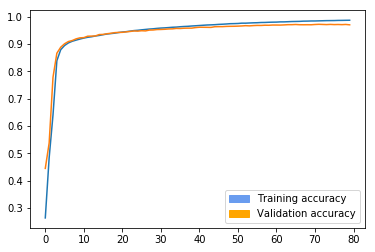

In [26]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(info['train_acc'])
ax1.plot(info['validation_acc'])
blue_patch = mpatches.Patch(color='#699cef', label='Training accuracy')
orange_patch = mpatches.Patch(color='orange', label='Validation accuracy')
ax1.legend(handles=[blue_patch, orange_patch])
plt.show()

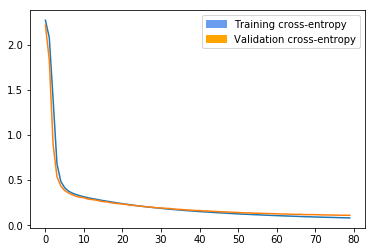

In [27]:
fig1 = plt.figure()
ax2 = fig1.add_subplot(111)
ax2.plot(info['train'])
ax2.plot(info['validation'])
blue_patch = mpatches.Patch(color='#699cef', label='Training cross-entropy')
orange_patch = mpatches.Patch(color='orange', label='Validation cross-entropy')
ax2.legend(handles=[blue_patch, orange_patch])
plt.show()

In [28]:
test_accuracy = accuracy(network.run(testX_processed), testY_processed)
print("Test data accuracy: ", test_accuracy)

Test data accuracy:  0.9716
